# References


**Datasets used in this assignment**

The assignment is implemented with the following dataset: CIFAR, FashionMNIST0.5 and FashionMNIST0.6

**References for Python libraries used in this assignment**

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2. (Publisher link).

Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., Killeen, T., Lin, Z., Gimelshein, N., Antiga, L., Desmaison, A., Köpf, A., Yang, E., DeVito, Z., Raison, M., Tejani, A., Chilamkurthy, S., Steiner, B., Lu, F., … Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. arXiv.org.

#1.Setup
The instruction to run this code on Google Colab is as follows:

Step 1: Create a folder **COMP5328 - Assignment 2** and sub-folder **Datasets** on Google Drive.

Step 2: Unzip the file that contains images of CIFAR, FashionMNIST0.5 and FashionMNIST0.6.

Step 3: Save the datasets of CIFAR, FashionMNIST0.5 and FashionMNIST0.6 in the newly created sub-folder **Datasets** in **COMP5328 - Assignment 2** on Google Drive.

Step 4: Run the section **1.Setup** and **2.Evaluation Metrics** to load the dataset and define evaluation metrics for estimated transition matrix and trained model.

Step 5: for estimation of transition mattix, kindly run the code in Section *3.1, 3.2 and 3.3*. If not implementing the estimation of transition matrix, kindkly follow the following steps:
- Run the code in Section **3.4** to load all transition matrices 
- Run the code in Section *4* to set up the settings for evaluation of 02 classifiers
 - For evaluation of Classifier 1, kindly run the code in **Section 5.1 and 5.5**
 - For evaluation of Classifier 2, kindly run the code in **Section 6.1 and 6.2**
         

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
import os
import random
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models
import torchvision.transforms

from sklearn.model_selection import train_test_split

import numpy as np
import numpy.linalg as lng
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Retrieve the current directory
current_dir = Path.cwd()

# Reference the directory of Assignment 2
img_dataset_dir = current_dir / "drive/MyDrive/COMP5328 - Assignment 2/Datasets"

# Reference the directory for trained model storage
trained_model_dir = current_dir / "drive/MyDrive/COMP5328 - Assignment 2/Trained Models"

# Create folder on Google Drive to save trained model
if not trained_model_dir.exists():
  trained_model_dir.mkdir()

# -----------------------------------------------------------------------------

# If using a relative path on a personal machine, uncomment this
# img_dataset_dir = "Datasets" 

# Run this code line if running the code file on Google Colab
img_dataset_dir = current_dir / "drive/MyDrive/COMP5328 - Assignment 2/Datasets"

cifar_dir = img_dataset_dir / "CIFAR.npz"
fashion_mnist05_dir = img_dataset_dir / "FashionMNIST0.5.npz"
fashion_mnist06_dir = img_dataset_dir / "FashionMNIST0.6.npz"

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# The random seeds are fixed to have the python runtime environment become deterministic.
def seed_torch(seed=10):
    """
    Function to set seed
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # If multi-GPUs are used. 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set seed
seed_torch()

In [5]:
# Create a DatasetArray class, which is used as an input of the DataLoader object.
class DatasetArray(Dataset):
    r"""This is a child class of the pytorch Dataset object."""
    def __init__(self, data, labels):
        self.data_arr = data.astype(np.float32)
        self.label_arr = labels.astype(np.int_)
        
    def __len__(self):
        return len(self.data_arr)
    
    def __getitem__(self, index):
     
        data = self.data_arr[index]
        label = self.label_arr[index]

        return (data, label)

## 1.1 Load Data

Define functions for data loading and present samples of the FashionMINIST0.5, FashionMINIST0.6 and CIFAR datasets.

In [6]:
def load_data(data_dir):
    """
    input: data directory
    ouput: loaded and normalized data 
    """

    loaded_data = np.load(data_dir)

    # Load and normalize features of training and validation data
    data_Xtr_val = loaded_data['Xtr'] / 255

    # Load labels of training and validation data
    data_Ytr_val = loaded_data['Str']

    # Load and normalize features of test data
    data_Xts = loaded_data['Xts'] / 255

    # Load clean labels
    data_Yts = loaded_data['Yts']

    # Rearrange the dimensions of data
    if data_Xtr_val.ndim == 4: #CIFAR data
        data_Xtr_val = np.rollaxis(data_Xtr_val, 3, 1) # from (15000, 32, 32, 3) to (15000, 3, 32, 32)
        data_Xts = np.rollaxis(data_Xts, 3, 1) # from (3000, 32, 32, 3) to (3000, 3, 32, 32)

    elif data_Xtr_val.ndim == 3: #MNIST data
        data_Xtr_val = np.rollaxis(data_Xtr_val[:,:,:,np.newaxis], 3, 1) # from (18000, 28, 28) to (18000, 1, 28, 28)
        data_Xts = np.rollaxis(data_Xts[:,:,:,np.newaxis], 3, 1) # from (3000, 28, 28) to (3000, 1, 28, 28)

    return data_Xtr_val, data_Ytr_val, data_Xts, data_Yts

### 1.1.1 CIFAR Dataset

In [7]:
cifar_data_Xtr_val, cifar_data_Ytr_val, cifar_data_Xts, cifar_data_Yts = load_data(cifar_dir)

print('CIFAR: Xtr.shape = {}, Ytr.shape = {}'.format(cifar_data_Xtr_val.shape, cifar_data_Ytr_val.shape))
print('CIFAR: Xts.shape = {}, Yts.shape = {}'.format(cifar_data_Xts.shape, cifar_data_Yts.shape))

CIFAR: Xtr.shape = (15000, 3, 32, 32), Ytr.shape = (15000,)
CIFAR: Xts.shape = (3000, 3, 32, 32), Yts.shape = (3000,)


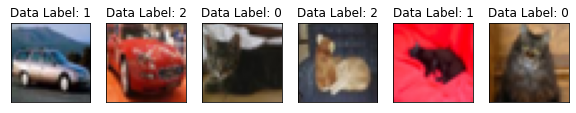

In [8]:
# Examples of loaded noisy data
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(np.transpose(cifar_data_Xtr_val[i], (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())

    label = cifar_data_Ytr_val[i]
    plt.title("Data Label: {}".format(label), size=12)

### 1.1.2 FashionMNIST0.5 Dataset

In [9]:
fashion_mnist05_Xtr_val, fashion_mnist05_Ytr_val, fashion_mnist05_data_Xts, fashion_mnist05_data_Yts = load_data(fashion_mnist05_dir)

print('FashionMNIST0.5: Xtr.shape = {}, Ytr.shape = {}'.format(fashion_mnist05_Xtr_val.shape, fashion_mnist05_Ytr_val.shape))
print('FashionMNIST0.5: Xts.shape = {}, Yts.shape = {}'.format(fashion_mnist05_data_Xts.shape, fashion_mnist05_data_Yts.shape))

FashionMNIST0.5: Xtr.shape = (18000, 1, 28, 28), Ytr.shape = (18000,)
FashionMNIST0.5: Xts.shape = (3000, 1, 28, 28), Yts.shape = (3000,)


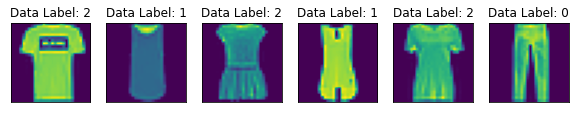

In [10]:
# Examples of loaded noisy data
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(np.squeeze(np.transpose(fashion_mnist05_Xtr_val[i], (1, 2, 0))))
    plt.xticks(())
    plt.yticks(())

    label = fashion_mnist05_Ytr_val[i]
    plt.title("Data Label: {}".format(label), size=12)

### 1.1.3 FashionMNIST0.6 Dataset

In [11]:
fashion_mnist06_Xtr_val, fashion_mnist06_Ytr_val, fashion_mnist06_data_Xts, fashion_mnist06_data_Yts = load_data(fashion_mnist06_dir)

print('FashionMNIST0.6: Xtr.shape = {}, Ytr.shape = {}'.format(fashion_mnist06_Xtr_val.shape, fashion_mnist06_Ytr_val.shape))
print('FashionMNIST0.6: Xts.shape = {}, Yts.shape = {}'.format(fashion_mnist06_data_Xts.shape, fashion_mnist06_data_Yts.shape))

FashionMNIST0.6: Xtr.shape = (18000, 1, 28, 28), Ytr.shape = (18000,)
FashionMNIST0.6: Xts.shape = (3000, 1, 28, 28), Yts.shape = (3000,)


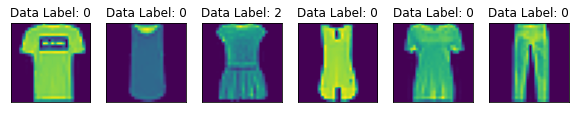

In [12]:
# Examples of loaded noisy data
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(np.squeeze(np.transpose(fashion_mnist06_Xtr_val[i], (1, 2, 0))))
    plt.xticks(())
    plt.yticks(())

    label = fashion_mnist06_Ytr_val[i]

    plt.title("Data Label: {}".format(label), size=12)

### 1.1.4 Load Transition Matrix

In [13]:
transition_matrices = {'fashionmnist0.5': torch.Tensor([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]]),
                       'fashionmnist0.6': torch.Tensor([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]]),
                       'cifar': None}

#2.Evaluation Metrics

**Accuracy (Top-1)**

In [14]:
# Calcuate the accuracy according to the prediction and the true label.
def accuracy(output, target, topk=(1,)):
    
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

**Relative Error**

In [15]:
def relative_error(T_hat, T):
    """
    T_hat: The estimated transition matrix
    T: The provided transition matrix
    """
    rre_numerator = np.linalg.norm(T_hat-T, ord = "fro")
    rre_denominator = np.linalg.norm(T_hat, ord = "fro") 
    rre = rre_numerator/rre_denominator
    return rre

#3.Transition Matrix

**Load Data**

In [16]:
cifar_train_data = DatasetArray(data = cifar_data_Xtr_val, labels = cifar_data_Ytr_val)
cifar_train_loader = DataLoader(
    cifar_train_data,
    batch_size = 128,
    shuffle = True,
    num_workers = 1)

fashion_mnist05_train_data = DatasetArray(data = fashion_mnist05_Xtr_val, labels = fashion_mnist05_Ytr_val)
fashion_mnist05_train_loader = DataLoader(
    fashion_mnist05_train_data,
    batch_size = 128,
    shuffle = True,
    num_workers = 1)

fashion_mnist06_train_data = DatasetArray(data = fashion_mnist06_Xtr_val, labels = fashion_mnist06_Ytr_val)
fashion_mnist06_train_loader = DataLoader(
    fashion_mnist06_train_data,
    batch_size = 128,
    shuffle = True,
    num_workers = 1)

**Training Processes**

The ResNet18 model, predefined in TorchVision, is used with the below training and evaluation processes to estimate the transition matrix. Predefined weights are not used.

In [17]:
# Define the training process.
def train(data_loader, model, n_epochs = 15):

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 1e-5)
    loss_function = torch.nn.CrossEntropyLoss()

    # Set model to train mode
    model.to(device)
    model.train()
    best_model_weights = deepcopy(model.state_dict())

    for n_epoch in range(n_epochs):

        model_loss = 0.0
        correct_prediction = 0
        total = 0

        for batch_i, (X, Y) in enumerate(data_loader):
            # prepare data input
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)

            loss = loss_function(output, Y)

            _, prediction = torch.max(output, 1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += Y.size(0)
        
            model_loss += loss.item() * X.size(0)

            correct_prediction += torch.sum(prediction == Y.data)
            # if batch_i % 100 == 0: # Output Results
            #   print("Epoch {} - Loss of batch {} is: {:.4f} and {}".format(n_epoch, batch_i, loss.item(), model_loss))

        # calculate loss and accuracy
        epoch_loss = model_loss / len(data_loader.dataset)
        epoch_acc = correct_prediction / total
    
        # record accuary and cross entropy losss
        print("Train epoch is: {} and Model Loss and Accuracy are: {} and {}%".format(n_epoch + 1, round(epoch_loss, 3), torch.round(100 * epoch_acc)))

    model.load_state_dict(best_model_weights)

    return model

In [18]:
# Calcuate the accuracy according to the predicted and the true labels.
def eval(model, val_data_loader, device):
  
    model.eval()

    # Create tesors that store results of predicted labels 
    y_true = torch.tensor([], dtype = torch.long, device = device)
    all_labels = torch.tensor([], device = device)

    with torch.no_grad():
        for inputs, labels in val_data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            predicted_labels = model(inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_labels = torch.cat((all_labels, predicted_labels), 0)

    # Obtain the outputs from softmax function:
    outputs = F.softmax(all_labels, dim = 1)

    # Convert the true labels to numpy
    y_true = y_true.cpu().numpy()

    # Get predicted values from the model
    _, y_pred = torch.max(all_labels, 1)
  
    # Convert the predicted labels to numpy
    y_pred = y_pred.cpu().numpy()
  
    # Calculate model accuracy
    model_accuracy = sum(y_true == y_pred)/len(y_pred)

    return y_true, y_pred, model_accuracy, outputs

In [19]:
def estimate_transition_matrix(model, train_data_loader, device = device, epochs = 15):
    trained_model = train(data_loader = train_data_loader, model = model, n_epochs = epochs)

    _, y_pred, _, noisy_class_posterior = eval(model = trained_model, val_data_loader = train_data_loader, device = device) # Softmax
    prediction = torch.argmax(noisy_class_posterior, dim = 0) # Anchor Points
    
#     print(noisy_class_posterior)
#     print(noisy_class_posterior.shape)

#     print(prediction)
#     print(prediction.shape)
        
    T = torch.zeros((3, 3))
    for class_i in range(3):
        T[class_i] = noisy_class_posterior[prediction[class_i]]

    return T.detach().numpy()

# -----------------------------------------------------------------------------

### 3.1 CIFAR

**Estimate Transition Matrix**

In [20]:
seed_torch()

model = torchvision.models.resnet18(weights = None).to(device) # Not using pretrained weights
model.fc = nn.Linear(model.fc.in_features, 3)
cifar_Tmatrix = estimate_transition_matrix(model, cifar_train_loader, device, epochs = 15)

print("\n")
print("The estimated Transition Matrix is:\n")
print(cifar_Tmatrix)

Train epoch is: 1 and Model Loss and Accuracy are: 1.158 and 35.0%
Train epoch is: 2 and Model Loss and Accuracy are: 1.108 and 37.0%
Train epoch is: 3 and Model Loss and Accuracy are: 1.067 and 43.0%
Train epoch is: 4 and Model Loss and Accuracy are: 1.021 and 48.0%
Train epoch is: 5 and Model Loss and Accuracy are: 0.958 and 54.0%
Train epoch is: 6 and Model Loss and Accuracy are: 0.877 and 60.0%
Train epoch is: 7 and Model Loss and Accuracy are: 0.802 and 65.0%
Train epoch is: 8 and Model Loss and Accuracy are: 0.71 and 70.0%
Train epoch is: 9 and Model Loss and Accuracy are: 0.607 and 75.0%
Train epoch is: 10 and Model Loss and Accuracy are: 0.532 and 78.0%
Train epoch is: 11 and Model Loss and Accuracy are: 0.483 and 81.0%
Train epoch is: 12 and Model Loss and Accuracy are: 0.402 and 84.0%
Train epoch is: 13 and Model Loss and Accuracy are: 0.324 and 88.0%
Train epoch is: 14 and Model Loss and Accuracy are: 0.296 and 89.0%
Train epoch is: 15 and Model Loss and Accuracy are: 0.247 

### 3.2 FashionMNIST0.5

**Estimate Transition Matrix**

In [21]:
seed_torch()

model = torchvision.models.resnet18(weights = None).to(device) # Not using pretrained weights
model.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 3)

fashion_mnist05_Tmatrix = estimate_transition_matrix(model, fashion_mnist05_train_loader, device, epochs = 15)

print("\n")
print("The estimated Transition Matrix is:\n")
print(fashion_mnist05_Tmatrix)

Train epoch is: 1 and Model Loss and Accuracy are: 1.109 and 42.0%
Train epoch is: 2 and Model Loss and Accuracy are: 1.046 and 47.0%
Train epoch is: 3 and Model Loss and Accuracy are: 1.004 and 51.0%
Train epoch is: 4 and Model Loss and Accuracy are: 0.963 and 53.0%
Train epoch is: 5 and Model Loss and Accuracy are: 0.906 and 58.0%
Train epoch is: 6 and Model Loss and Accuracy are: 0.868 and 60.0%
Train epoch is: 7 and Model Loss and Accuracy are: 0.817 and 63.0%
Train epoch is: 8 and Model Loss and Accuracy are: 0.756 and 67.0%
Train epoch is: 9 and Model Loss and Accuracy are: 0.71 and 69.0%
Train epoch is: 10 and Model Loss and Accuracy are: 0.654 and 72.0%
Train epoch is: 11 and Model Loss and Accuracy are: 0.615 and 74.0%
Train epoch is: 12 and Model Loss and Accuracy are: 0.553 and 77.0%
Train epoch is: 13 and Model Loss and Accuracy are: 0.544 and 77.0%
Train epoch is: 14 and Model Loss and Accuracy are: 0.48 and 80.0%
Train epoch is: 15 and Model Loss and Accuracy are: 0.443 a

**Evaluate Accuracy**

In [22]:
fashion_mnist05_re = relative_error(fashion_mnist05_Tmatrix, transition_matrices['fashionmnist0.5'].detach().numpy())
print(fashion_mnist05_re) 

0.29142883


### 3.3. FashionMNIST0.6

**Estimate Transition Matrix**

In [23]:
seed_torch()

model = torchvision.models.resnet18(weights = None).to(device) # Not using pretrained weights
model.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 3)

fashion_mnist06_Tmatrix = estimate_transition_matrix(model, fashion_mnist06_train_loader, device, epochs = 15)

print("\n")
print("The estimated Transition Matrix is:\n")
print(fashion_mnist06_Tmatrix)

Train epoch is: 1 and Model Loss and Accuracy are: 1.156 and 35.0%
Train epoch is: 2 and Model Loss and Accuracy are: 1.101 and 39.0%
Train epoch is: 3 and Model Loss and Accuracy are: 1.058 and 44.0%
Train epoch is: 4 and Model Loss and Accuracy are: 1.018 and 49.0%
Train epoch is: 5 and Model Loss and Accuracy are: 0.968 and 53.0%
Train epoch is: 6 and Model Loss and Accuracy are: 0.926 and 56.0%
Train epoch is: 7 and Model Loss and Accuracy are: 0.88 and 59.0%
Train epoch is: 8 and Model Loss and Accuracy are: 0.837 and 62.0%
Train epoch is: 9 and Model Loss and Accuracy are: 0.78 and 65.0%
Train epoch is: 10 and Model Loss and Accuracy are: 0.726 and 68.0%
Train epoch is: 11 and Model Loss and Accuracy are: 0.67 and 71.0%
Train epoch is: 12 and Model Loss and Accuracy are: 0.633 and 72.0%
Train epoch is: 13 and Model Loss and Accuracy are: 0.575 and 76.0%
Train epoch is: 14 and Model Loss and Accuracy are: 0.529 and 78.0%
Train epoch is: 15 and Model Loss and Accuracy are: 0.494 an

**Evaluate Accuracy**

In [24]:
fashion_mnist06_re = relative_error(fashion_mnist06_Tmatrix, transition_matrices['fashionmnist0.6'].detach().numpy())
print(fashion_mnist06_re)

0.07984894


### 3.4. Adding estimated Transition Matrix for CIFAR

In [25]:
transition_matrices['cifar'] = torch.Tensor([[0.4009205, 0.21704781, 0.38203168], 
                                             [0.34578598, 0.31487453, 0.33933955], 
                                             [0.35156542, 0.23229724, 0.41613737]])

# Print all transition matrices:
transition_matrices

{'fashionmnist0.5': tensor([[0.5000, 0.2000, 0.3000],
         [0.3000, 0.5000, 0.2000],
         [0.2000, 0.3000, 0.5000]]),
 'fashionmnist0.6': tensor([[0.4000, 0.3000, 0.3000],
         [0.3000, 0.4000, 0.3000],
         [0.3000, 0.3000, 0.4000]]),
 'cifar': tensor([[0.4009, 0.2170, 0.3820],
         [0.3458, 0.3149, 0.3393],
         [0.3516, 0.2323, 0.4161]])}

#4.Evaluation Functions

### 4.1 Define function to split the data for training and validation

#### Define function to split the data for an experiment in sections 5.3 and 5.4

In [26]:
def data_loader_function(train_val_data, train_val_label, test_data, test_label, random_state = 12, data_split = 0.2, batch_size = 100, num_workers = 1):
    """
    - Input:
    train_val_data: dataset contains training and validation data
    train_val_label: dataset contains labels of training and validation data
    test_data: dataset contains test data (data without noise)
    test_label: dataset contains labels of test data (data without noise)
    data_split: ratio to split dataset into training and validation datasets
    batch_size: size of each batch loaded to cnn model
    num_workers: 1 (default value)
    - Output:
    The corresponding DataLoader objects (train data, validation data and test data) are returned
    """
    
    train_data, val_data, train_label, val_label = train_test_split(train_val_data, 
                                                                    train_val_label, 
                                                                    test_size = data_split, 
                                                                    random_state = random_state,
                                                                    stratify = train_val_label)

    train_data = DatasetArray(data = train_data, labels = train_label)
    val_data = DatasetArray(data = val_data, labels = val_label)
    test_data = DatasetArray(data = test_data, labels = test_label)

    train_loader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers,
    )

    val_loader = DataLoader(
        val_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = num_workers,
    )

    test_loader = DataLoader(
        test_data,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = False,
    )

    return train_loader, val_loader, test_loader

#### Define function to split the data for an performance evaluation in sections 5.5 and 6.2

In [27]:
def data_loader_for_evaluation_function(train_val_data, train_val_label, test_data, test_label, data_split = 0.2, batch_size = 100, num_workers = 1):
    """
    - Input:
    train_val_data: dataset contains training and validation data
    train_val_label: dataset contains labels of training and validation data
    test_data: dataset contains test data (data without noise)
    test_label: dataset contains labels of test data (data without noise)
    data_split: ratio to split dataset into training and validation datasets (default value: 0.2)
    batch_size: size of each batch loaded to cnn model
    num_workers: 1 (default value)
    - Output:
    The corresponding DataLoader objects (train data, validation data and test data) are returned
    """
    
    # Split dataset into 80% training and 20% validation 
    train_data, val_data, train_label, val_label = train_test_split(train_val_data, 
                                                                    train_val_label, 
                                                                    test_size = data_split)

    train_data = DatasetArray(data = train_data, labels = train_label)
    val_data = DatasetArray(data = val_data, labels = val_label)
    test_data = DatasetArray(data = test_data, labels = test_label)

    train_loader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers,
    )

    val_loader = DataLoader(
        val_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = num_workers,
    )

    test_loader = DataLoader(
        test_data,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = False,
    )

    return train_loader, val_loader, test_loader

### 4.2 Define function to evaluate model performance

In [28]:
# A helper function which is used to record the experiment results.
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

In [29]:
# def evaluation_function(epoch, model, loss_function, val_loader, is_test=False):
def evaluation_function(epoch, model, loss_function, val_loader):
    """This function is used to evaluate the performance of model."""
    
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to eval mode
    model.eval()
    for step, (data, targets) in enumerate(val_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        with torch.no_grad():
            preds = model(data)

        # forward
        loss = loss_function(preds, targets)
            
        # calculate accuracy
        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,))
  
        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    top1_acc_avg = top1_acc_meter.avg

    return top1_acc_avg

### 4.3 Define function to train model with and without Transition Matrix

This function is created to train, evaluate model and predict the labels in test dataset (data without noise). And to predict the true labels with transition matrix, the **forward learning method** is applied.   

In [30]:
def train_and_eval_model(n_epochs, model, data_train_loader, data_val_loader, data_test_loader, T_matrix, optimizer, loss_function, optim_config, run_with_Tmatrix = False):
    """
    Training a pytorch cnn model
    Input:
    - n_epochs: number of epochs to train cnn model
    - model: cnn model 
    - data_train_loader: training data created to train cnn model
    - data_val_loader: validation data created to test performance of cnn model
    - data_test_loader: test dataset (without noise)
    - T_matrix: estimated transition matrix
    - optimizer: optimization function
    - loss_function: loss function 
    - optim_config: optimal configuration selected to train cnn model
    - run_with_Tmatrix: False (default value), True: when running with transition matrix
    Ouput:
    - model: trained model after a number of epochs 
    - best_top1_acc: best top-1 accuracy 
    - model_test_accuracy: the accuracy of trained model on with test dataset (data without noise)
    """

    val_acc_hist = []
    best_top1_acc = 0
    best_model_weights = deepcopy(model.state_dict())

    for epoch in range(n_epochs):
        # top1_acc_meter = AverageMeter()
        # loss_meter = AverageMeter()

        print("-----")

        for stage in ["train", "eval"]:

            if stage == "train":

                model_loss = 0.0
                correct_prediction = 0
                total = 0

                # Set model to train mode
                model.to(device)
                model.train()
    
                for i, (input_data, label_data) in enumerate(data_train_loader):
              
                    # prepare data input
                    input_data = input_data.to(device)
                    label_data = label_data.to(device)

                    # Set zero to the parameter gradients
                    optimizer.zero_grad()
              
                    # predict labels
                    output = model(input_data)

                    # # forward
                    # loss = loss_function(output, label_data)
              
                    # Prediction with transition matrix (forward learning)
                    if run_with_Tmatrix:

                        prob = F.softmax(output, dim=1)
                        output = torch.matmul(T_matrix.to(device), prob.t())
                        output = output.t()
                        _, predicted_label = torch.max(output, 1)

                    # Prediction without transition matrix
                    else:
                        output = output
                        _, predicted_label = torch.max(output, 1)

                    # forward
                    loss = loss_function(output, label_data)

                    # backward
                    loss.backward()

                    # update all gradients
                    optimizer.step()
              
                    total += label_data.size(0)
                    model_loss += loss.item() * input_data.size(0)

                    correct_prediction += torch.sum(predicted_label == label_data.data)

                # calculate loss and accuracy
                epoch_loss = model_loss / len(data_train_loader.dataset)
                epoch_acc = correct_prediction / total
    
                # record accuary and cross entropy losss
                if epoch % 2 == 0:
                    print("Train epoch is: {} and Model Loss and Accuracy are: {} and {}%".format(epoch + 1, round(epoch_loss, 3), torch.round(100 * epoch_acc)))

            else:          
                # Perform model validation
                top1_acc_avg = evaluation_function(epoch = epoch, model = model, loss_function = loss_function, val_loader = data_val_loader)
                if epoch % 2 == 0:
                    print("Model validation: Top-1 Accuracy is: {}%".format(round(top1_acc_avg, 2)))

            # save the best model
            if stage == "eval" and (top1_acc_avg > best_top1_acc):
                state = OrderedDict([
                    ('config', optim_config),
                    ('state_dict', model.state_dict()),
                    ('optimizer', optimizer.state_dict()),
                    ('epoch', epoch),
                    ('top1-accuracy', top1_acc_avg),
                ])
                best_model_path = os.path.join(trained_model_dir, 'best_model.pth')
                torch.save(state, best_model_path)
                best_top1_acc = top1_acc_avg
                best_model_weights = deepcopy(model.state_dict())

    # Load the best model      
    model.load_state_dict(best_model_weights)

    # Evaluatate the model with test dataset
    model_test_accuracy = evaluation_function(epoch = n_epochs, 
                                              model = model, 
                                              loss_function = loss_function, 
                                              val_loader = data_test_loader
                                              )
    print('Accuracy of test dataset is: {:2f}%'.format(round(model_test_accuracy, 2)))

    return model, best_top1_acc, model_test_accuracy

#5.Classifier 1

### 5.1 Model architecture

In [31]:
# Define a CNN class.
class Classifier1(nn.Module):

    def __init__(self, n_classes = 3, n_filters = 20, in_channels = 1):
        super(Classifier1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 10, kernel_size = 5, stride = 1)
        self.bn1 = nn.BatchNorm2d(10)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(10, 30, kernel_size = 5, stride = 1)
        self.bn2 = nn.BatchNorm2d(30)
        self.relu = nn.ReLU()

        self.FC_input_layer = nn.Linear(30*n_filters*n_filters, 500)

        self.drop = nn.Dropout(0.25)
        
        self.FC_hidden_layer1 = nn.Linear(500, 200)
        self.FC_hidden_layer2 = nn.Linear(200, 100)

        self.FC_output_layer = nn.Linear(100, n_classes)

    def forward(self, output):
        """The structure of CNN model is as follows:
        conv1->bn1->relu->cov2->bn2->relu->
        input_layer->relu->dropout->hidden_layer1->relu->hidden_layer2->relu->output_layer
        """

        output = self.conv1(output)
        output = self.bn1(output)
        output = F.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = F.relu(output)

        output = output.view(output.size(0), -1)
        output = F.relu(self.FC_input_layer(output))

        output = self.drop(output)

        output = F.relu(self.FC_hidden_layer1(output))
        output = F.relu(self.FC_hidden_layer2(output))

        output = self.FC_output_layer(output)

        return output     

### 5.2 Initialise and Define Configuration

In [32]:
classifier1_model = Classifier1().to(device)

# Define optimal config:
optim_config = OrderedDict([
    ('epochs', 10),
    ('batch_size', 128),
    ('lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.1)
])

# Define criterion and optimizer
loss_function_classifier1 = nn.CrossEntropyLoss()
optimizer_classifier1 = torch.optim.SGD(params = classifier1_model.parameters(),
                                        lr = optim_config['lr'], 
                                        momentum = optim_config['momentum'],
                                        weight_decay = optim_config['weight_decay'])

train_loader, val_loader, test_loader = data_loader_function(train_val_data = fashion_mnist05_Xtr_val, 
                                                             train_val_label = fashion_mnist05_Ytr_val, 
                                                             test_data = fashion_mnist05_data_Xts, 
                                                             test_label = fashion_mnist05_data_Yts,
                                                             batch_size = optim_config['batch_size'])

### 5.3 Experiment: Train without Transition Matrix [FashionMNIST05]

In [33]:
seed_torch()

# Transition matrix is not used
classifier1_cnn_model_without_TM, _, model_test_accuracy_without_TM = train_and_eval_model(n_epochs = optim_config['epochs'], 
                                    model = classifier1_model, 
                                    data_train_loader = train_loader,
                                    data_val_loader = val_loader,
                                    data_test_loader = test_loader,
                                    T_matrix = transition_matrices['fashionmnist0.5'],
                                    optimizer = optimizer_classifier1, 
                                    loss_function = loss_function_classifier1,
                                    optim_config = optim_config,
                                    run_with_Tmatrix = False)

-----
Train epoch is: 1 and Model Loss and Accuracy are: 1.061 and 46.0%
Model validation: Top-1 Accuracy is: 46.83%
-----
-----
Train epoch is: 3 and Model Loss and Accuracy are: 1.042 and 48.0%
Model validation: Top-1 Accuracy is: 49.14%
-----
-----
Train epoch is: 5 and Model Loss and Accuracy are: 1.028 and 50.0%
Model validation: Top-1 Accuracy is: 48.89%
-----
-----
Train epoch is: 7 and Model Loss and Accuracy are: 1.006 and 51.0%
Model validation: Top-1 Accuracy is: 47.08%
-----
-----
Train epoch is: 9 and Model Loss and Accuracy are: 0.973 and 53.0%
Model validation: Top-1 Accuracy is: 46.56%
-----
Accuracy of test dataset is: 93.230000%


###5.4 Experiment: Train with Transition Matrix [FashionMNIST05]

In [34]:
seed_torch()

# Transition matrix is used
classifier1_cnn_model_with_TM, _, model_test_accuracy_with_TM = train_and_eval_model(n_epochs = optim_config['epochs'], 
                                    model = classifier1_model, 
                                    data_train_loader = train_loader,
                                    data_val_loader = val_loader,
                                    data_test_loader = test_loader,
                                    T_matrix = transition_matrices['fashionmnist0.5'],
                                    optimizer = optimizer_classifier1, 
                                    loss_function = loss_function_classifier1,
                                    optim_config = optim_config,
                                    run_with_Tmatrix = True)

-----
Train epoch is: 1 and Model Loss and Accuracy are: 1.083 and 46.0%
Model validation: Top-1 Accuracy is: 48.72%
-----
-----
Train epoch is: 3 and Model Loss and Accuracy are: 1.065 and 49.0%
Model validation: Top-1 Accuracy is: 49.28%
-----
-----
Train epoch is: 5 and Model Loss and Accuracy are: 1.064 and 49.0%
Model validation: Top-1 Accuracy is: 49.28%
-----
-----
Train epoch is: 7 and Model Loss and Accuracy are: 1.063 and 49.0%
Model validation: Top-1 Accuracy is: 49.31%
-----
-----
Train epoch is: 9 and Model Loss and Accuracy are: 1.062 and 50.0%
Model validation: Top-1 Accuracy is: 49.17%
-----
Accuracy of test dataset is: 94.030000%


### 5.5 Performance Evaluation

In [35]:
dataset_list = {"cifar": [cifar_data_Xtr_val, cifar_data_Ytr_val, cifar_data_Xts, cifar_data_Yts],
            "fashionmnist0.5": [fashion_mnist05_Xtr_val, fashion_mnist05_Ytr_val, fashion_mnist05_data_Xts, fashion_mnist05_data_Yts],
            "fashionmnist0.6": [fashion_mnist06_Xtr_val, fashion_mnist06_Ytr_val, fashion_mnist06_data_Xts, fashion_mnist06_data_Yts]}

In [36]:
# Set the number of times to run the model
n_iters = 10

# Create a dictionary to store list of all experimental results
model1_test_acc_dict = {
                        "cifar": [list(), list()], #1st list is for accuracy without transition matrix, 2nd for accuracy with transition matrix
                        "fashionmnist0.5": [list(), list()],
                        "fashionmnist0.6": [list(), list()]
                        }

# Define optimal config:
optim_config_classifier1 = OrderedDict([
    ('epochs', 15),
    ('batch_size', 128),
    ('lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.1)
])

#### 5.5.1 CIFAR

##### Without Transition Matrix

In [ ]:
dataset = "cifar"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))
print("\n")

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):
  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier1["batch_size"])
  
  # Initiate the model
  cnn_model = Classifier1(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier1 = nn.CrossEntropyLoss()
  optimizer_classifier1 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier1['lr'], 
                                        momentum = optim_config_classifier1['momentum'],
                                        weight_decay = optim_config_classifier1['weight_decay'])

  # Define criterion and optimizer
  loss_function_classifier1 = nn.CrossEntropyLoss()
  optimizer_classifier1 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier1['lr'], 
                                        momentum = optim_config_classifier1['momentum'],
                                        weight_decay = optim_config_classifier1['weight_decay'])

  print("The training iteration: {} - Without Transition Matrix".format(n_iter + 1)) 
  print("\n")
  # Train and evaluate model without Transition Matrix
  trained_model1_without_TM, _, model1_test_accuracy_without_TM = train_and_eval_model(n_epochs = optim_config_classifier1['epochs'], 
                                                                          model = cnn_model, 
                                                                          data_train_loader = train_loader,
                                                                          data_val_loader = val_loader,
                                                                          data_test_loader = test_loader,
                                                                          T_matrix = transition_matrices[dataset],
                                                                          optimizer = optimizer_classifier1, 
                                                                          loss_function = loss_function_classifier1,
                                                                          optim_config = optim_config_classifier1,
                                                                          run_with_Tmatrix = False)
  
  model1_test_acc_dict[dataset][0].append(model1_test_accuracy_without_TM)

print("Before Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model1_test_acc_dict[dataset][0][1:10]))))
print("Before Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model1_test_acc_dict[dataset][0][1:10]))))

----------
Experiments for dataset: cifar

Transition Matrix: 
tensor([[0.4009, 0.2170, 0.3820],
        [0.3458, 0.3149, 0.3393],
        [0.3516, 0.2323, 0.4161]])


The training iteration: 1
The training iteration: 1 - Without Transition Matrix


-----
Train epoch is: 1 and Model Loss and Accuracy are: 1.097 and 36.0%
Model validation: Top-1 Accuracy is: 35.7%
-----
-----
Train epoch is: 3 and Model Loss and Accuracy are: 1.083 and 39.0%
Model validation: Top-1 Accuracy is: 36.67%
-----
-----
Train epoch is: 5 and Model Loss and Accuracy are: 1.057 and 44.0%
Model validation: Top-1 Accuracy is: 34.47%
-----
-----
Train epoch is: 7 and Model Loss and Accuracy are: 1.01 and 49.0%
Model validation: Top-1 Accuracy is: 34.17%
-----
-----
Train epoch is: 9 and Model Loss and Accuracy are: 0.909 and 57.0%
Model validation: Top-1 Accuracy is: 35.47%
-----
-----
Train epoch is: 11 and Model Loss and Accuracy are: 0.765 and 66.0%
Model validation: Top-1 Accuracy is: 34.87%
-----
-----
Train e

##### With Transition Matrix

In [38]:
dataset = "cifar"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):
  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier1["batch_size"])
  
  # Initiate the model
  cnn_model = Classifier1(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier1 = nn.CrossEntropyLoss()
  optimizer_classifier1 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier1['lr'], 
                                        momentum = optim_config_classifier1['momentum'],
                                        weight_decay = optim_config_classifier1['weight_decay'])

  print("The training iteration: {} - With Transition Matrix".format(n_iter + 1)) 
  
  # Train and evaluate model with Transition Matrix
  trained_model1_with_TM, _, model1_test_accuracy_with_TM = train_and_eval_model(n_epochs = optim_config_classifier1['epochs'], 
                                                                                model = cnn_model, 
                                                                                data_train_loader = train_loader,
                                                                                data_val_loader = val_loader,
                                                                                data_test_loader = test_loader,
                                                                                T_matrix = transition_matrices[dataset],
                                                                                optimizer = optimizer_classifier1, 
                                                                                loss_function = loss_function_classifier1,
                                                                                optim_config = optim_config_classifier1,
                                                                                run_with_Tmatrix = True)
  
  model1_test_acc_dict[dataset][1].append(model1_test_accuracy_with_TM)

print("\nAfter Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model1_test_acc_dict[dataset][1][1:10]))))
print("After Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model1_test_acc_dict[dataset][1][1:10]))))

----------
Experiments for dataset: cifar

Transition Matrix: 
tensor([[0.4009, 0.2170, 0.3820],
        [0.3458, 0.3149, 0.3393],
        [0.3516, 0.2323, 0.4161]])
The training iteration: 1
The training iteration: 1 - With Transition Matrix
-----
Train epoch is: 1 and Model Loss and Accuracy are: 1.099 and 34.0%
Model validation: Top-1 Accuracy is: 34.2%
-----
-----
Train epoch is: 3 and Model Loss and Accuracy are: 1.099 and 35.0%
Model validation: Top-1 Accuracy is: 34.8%
-----
-----
Train epoch is: 5 and Model Loss and Accuracy are: 1.099 and 36.0%
Model validation: Top-1 Accuracy is: 34.87%
-----
-----
Train epoch is: 7 and Model Loss and Accuracy are: 1.098 and 37.0%
Model validation: Top-1 Accuracy is: 35.13%
-----
-----
Train epoch is: 9 and Model Loss and Accuracy are: 1.098 and 36.0%
Model validation: Top-1 Accuracy is: 35.4%
-----
-----
Train epoch is: 11 and Model Loss and Accuracy are: 1.098 and 36.0%
Model validation: Top-1 Accuracy is: 35.5%
-----
-----
Train epoch is: 

#### 5.5.2 FashionMNIST05

##### Without Transition Matrix

In [ ]:
dataset = "fashionmnist0.5"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))
print("\n")

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):
  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier1["batch_size"])
  
  # Initiate the model
  cnn_model = Classifier1(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier1 = nn.CrossEntropyLoss()
  optimizer_classifier1 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier1['lr'], 
                                        momentum = optim_config_classifier1['momentum'],
                                        weight_decay = optim_config_classifier1['weight_decay'])

  print("The training iteration: {} - Without Transition Matrix".format(n_iter + 1)) 
  print("\n")
  # Train and evaluate model without Transition Matrix
  trained_model1_without_TM, _, model1_test_accuracy_without_TM = train_and_eval_model(n_epochs = optim_config_classifier1['epochs'], 
                                                                          model = cnn_model, 
                                                                          data_train_loader = train_loader,
                                                                          data_val_loader = val_loader,
                                                                          data_test_loader = test_loader,
                                                                          T_matrix = transition_matrices[dataset],
                                                                          optimizer = optimizer_classifier1, 
                                                                          loss_function = loss_function_classifier1,
                                                                          optim_config = optim_config_classifier1,
                                                                          run_with_Tmatrix = False)
  
  model1_test_acc_dict[dataset][0].append(model1_test_accuracy_without_TM)

print("Before Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model1_test_acc_dict[dataset][0][1:10]))))
print("Before Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model1_test_acc_dict[dataset][0][1:10]))))

----------
Experiments for dataset: fashionmnist0.5

Transition Matrix: 
tensor([[0.5000, 0.2000, 0.3000],
        [0.3000, 0.5000, 0.2000],
        [0.2000, 0.3000, 0.5000]])


The training iteration: 1
The training iteration: 1 - Without Transition Matrix


-----
Train epoch is: 1 and Model Loss and Accuracy are: 1.063 and 45.0%
Model validation: Top-1 Accuracy is: 47.67%
-----
-----
Train epoch is: 3 and Model Loss and Accuracy are: 1.039 and 49.0%
Model validation: Top-1 Accuracy is: 47.22%
-----
-----
Train epoch is: 5 and Model Loss and Accuracy are: 1.024 and 50.0%
Model validation: Top-1 Accuracy is: 46.97%
-----
-----
Train epoch is: 7 and Model Loss and Accuracy are: 1.0 and 51.0%
Model validation: Top-1 Accuracy is: 46.17%
-----
-----
Train epoch is: 9 and Model Loss and Accuracy are: 0.952 and 54.0%
Model validation: Top-1 Accuracy is: 45.28%
-----
-----
Train epoch is: 11 and Model Loss and Accuracy are: 0.897 and 57.0%
Model validation: Top-1 Accuracy is: 45.36%
-----
---

##### With Transition Matrix

In [ ]:
dataset = "fashionmnist0.5"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):
  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier1["batch_size"])
  
  # Initiate the model
  cnn_model = Classifier1(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier1 = nn.CrossEntropyLoss()
  optimizer_classifier1 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier1['lr'], 
                                        momentum = optim_config_classifier1['momentum'],
                                        weight_decay = optim_config_classifier1['weight_decay'])

  print("The training iteration: {} - With Transition Matrix".format(n_iter + 1)) 
  
  # Train and evaluate model with Transition Matrix
  trained_model1_with_TM, _, model1_test_accuracy_with_TM = train_and_eval_model(n_epochs = optim_config_classifier1['epochs'], 
                                                                                model = cnn_model, 
                                                                                data_train_loader = train_loader,
                                                                                data_val_loader = val_loader,
                                                                                data_test_loader = test_loader,
                                                                                T_matrix = transition_matrices[dataset],
                                                                                optimizer = optimizer_classifier1, 
                                                                                loss_function = loss_function_classifier1,
                                                                                optim_config = optim_config_classifier1,
                                                                                run_with_Tmatrix = True)
  
  model1_test_acc_dict[dataset][1].append(model1_test_accuracy_with_TM)

print("\nAfter Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model1_test_acc_dict[dataset][1][1:10]))))
print("After Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model1_test_acc_dict[dataset][1][1:10]))))

#### 5.5.3 FashionMNIST06

##### Without Transition Matrix

In [ ]:
dataset = "fashionmnist0.6"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))
print("\n")

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):
  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier1["batch_size"])
  
  # Initiate the model
  cnn_model = Classifier1(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier1 = nn.CrossEntropyLoss()
  optimizer_classifier1 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier1['lr'], 
                                        momentum = optim_config_classifier1['momentum'],
                                        weight_decay = optim_config_classifier1['weight_decay'])

  print("The training iteration: {} - Without Transition Matrix".format(n_iter + 1)) 
  print("\n")
  # Train and evaluate model without Transition Matrix
  trained_model1_without_TM, _, model1_test_accuracy_without_TM = train_and_eval_model(n_epochs = optim_config_classifier1['epochs'], 
                                                                          model = cnn_model, 
                                                                          data_train_loader = train_loader,
                                                                          data_val_loader = val_loader,
                                                                          data_test_loader = test_loader,
                                                                          T_matrix = transition_matrices[dataset],
                                                                          optimizer = optimizer_classifier1, 
                                                                          loss_function = loss_function_classifier1,
                                                                          optim_config = optim_config_classifier1,
                                                                          run_with_Tmatrix = False)
  
  model1_test_acc_dict[dataset][0].append(model1_test_accuracy_without_TM)

print("Before Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model1_test_acc_dict[dataset][0][1:10]))))
print("Before Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model1_test_acc_dict[dataset][0][1:10]))))

##### With Transition Matrix

In [ ]:
dataset = "fashionmnist0.6"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):
  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier1["batch_size"])
                  
  # Initiate the model
  cnn_model = Classifier1(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier1 = nn.CrossEntropyLoss()
  optimizer_classifier1 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier1['lr'], 
                                        momentum = optim_config_classifier1['momentum'],
                                        weight_decay = optim_config_classifier1['weight_decay'])

  print("The training iteration: {} - With Transition Matrix".format(n_iter + 1)) 
  
  # Train and evaluate model with Transition Matrix
  trained_model1_with_TM, _, model1_test_accuracy_with_TM = train_and_eval_model(n_epochs = optim_config_classifier1['epochs'], 
                                                                                model = cnn_model, 
                                                                                data_train_loader = train_loader,
                                                                                data_val_loader = val_loader,
                                                                                data_test_loader = test_loader,
                                                                                T_matrix = transition_matrices[dataset],
                                                                                optimizer = optimizer_classifier1, 
                                                                                loss_function = loss_function_classifier1,
                                                                                optim_config = optim_config_classifier1,
                                                                                run_with_Tmatrix = True)
  
  model1_test_acc_dict[dataset][1].append(model1_test_accuracy_with_TM)

print("\nAfter Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model1_test_acc_dict[dataset][1][1:10]))))
print("After Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model1_test_acc_dict[dataset][1][1:10]))))

#6.Classifier 2

### 6.1 Model architecture

In [ ]:
# Define a CNN class.
class Classifier2(nn.Module):

    def __init__(self, n_classes = 3, n_filters = 20, in_channels = 1):
        super(Classifier2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size = 5, stride = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 48, kernel_size = 5, stride = 1)
        self.bn2 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU()

        self.FC_input_layer = nn.Linear(48*n_filters*n_filters, 128)

        self.drop = nn.Dropout(0.25)
        
        self.FC_hidden_layer1 = nn.Linear(128, 100)
        # self.FC_hidden_layer2 = nn.Linear(400, 200)
        # self.FC_hidden_layer3 = nn.Linear(200, 100)

        self.FC_output_layer = nn.Linear(100, n_classes)

    def forward(self, output):
        """The structure of CNN model is as follows:
        conv1->bn1->relu->cov2->bn2->relu->
        input_layer->relu->dropout->hidden_layer1->relu->hidden_layer2->relu->hidden_layer3->relu->output_layer
        """

        output = self.conv1(output)
        output = self.bn1(output)
        output = F.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = F.relu(output)

        output = output.view(output.size(0), -1)
        output = F.relu(self.FC_input_layer(output))

        output = self.drop(output)
        
        output = F.relu(self.FC_hidden_layer1(output))
        # output = F.relu(self.FC_hidden_layer2(output))
        # output = F.relu(self.FC_hidden_layer3(output))

        output = self.FC_output_layer(output)

        return output     

## 6.2 Performance Evaluation

In [ ]:
dataset_list = {'cifar': [cifar_data_Xtr_val, cifar_data_Ytr_val, cifar_data_Xts, cifar_data_Yts],
            'fashionmnist0.5': [fashion_mnist05_Xtr_val, fashion_mnist05_Ytr_val, fashion_mnist05_data_Xts, fashion_mnist05_data_Yts],
            'fashionmnist0.6': [fashion_mnist06_Xtr_val, fashion_mnist06_Ytr_val, fashion_mnist06_data_Xts, fashion_mnist06_data_Yts]}

In [ ]:
# Define optimal config:
optim_config_classifier2 = OrderedDict([
    ('epochs', 10),
    ('batch_size', 128),
    ('lr', 0.01),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.1)
])

# Set the number of times to run the model
n_iters = 10

# Create a dictionary to store list of all experimental results
model2_test_acc_dict = {
                        "cifar": [list(), list()], #1st list is for accuracy without transition matrix, 2nd for accuracy with transition matrix
                        "fashionmnist0.5": [list(), list()],
                        "fashionmnist0.6": [list(), list()]
                        }


#### 6.2.1 CIFAR

##### Without Transition Matrix

In [ ]:
dataset = "cifar"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):

  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier2["batch_size"])

  # Initiate the model
  cnn_model = Classifier2(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier2 = nn.CrossEntropyLoss()
  optimizer_classifier2 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier2['lr'], 
                                        momentum = optim_config_classifier2['momentum'],
                                        weight_decay = optim_config_classifier2['weight_decay'])

  print("The training iteration: {} - Without Transition Matrix".format(n_iter + 1)) 

  # Train and evaluate model without Transition Matrix
  trained_model2_without_TM, _, model2_test_accuracy_without_TM = train_and_eval_model(n_epochs = optim_config_classifier2['epochs'], 
                                                                            model = cnn_model, 
                                                                            data_train_loader = train_loader,
                                                                            data_val_loader = val_loader,
                                                                            data_test_loader = test_loader,
                                                                            T_matrix = transition_matrices[dataset],
                                                                            optimizer = optimizer_classifier2, 
                                                                            loss_function = loss_function_classifier2,
                                                                            optim_config = optim_config_classifier2,
                                                                            run_with_Tmatrix = False)

  model2_test_acc_dict[dataset][0].append(model2_test_accuracy_without_TM)

print("\nBefore Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model2_test_acc_dict[dataset][0][1:10])), 2))
print("Before Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model2_test_acc_dict[dataset][0][1:10])), 3))

##### With Transition Matrix

In [ ]:
dataset = "cifar"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):

  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier2["batch_size"])

  # Initiate the model
  cnn_model = Classifier2(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier2 = nn.CrossEntropyLoss()
  optimizer_classifier2 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier2['lr'], 
                                        momentum = optim_config_classifier2['momentum'],
                                        weight_decay = optim_config_classifier2['weight_decay'])  
  
  print("The training iteration: {} - With Transition Matrix".format(n_iter + 1)) 
  # Train and evaluate model with Transition Matrix
  trained_model2_with_TM, _, model2_test_accuracy_with_TM = train_and_eval_model(n_epochs = optim_config_classifier2['epochs'], 
                                                                                model = cnn_model, 
                                                                                data_train_loader = train_loader,
                                                                                data_val_loader = val_loader,
                                                                                data_test_loader = test_loader,
                                                                                T_matrix = transition_matrices[dataset],
                                                                                optimizer = optimizer_classifier2, 
                                                                                loss_function = loss_function_classifier2,
                                                                                optim_config = optim_config_classifier2,
                                                                                run_with_Tmatrix = True)

  model2_test_acc_dict[dataset][1].append(model2_test_accuracy_with_TM)

print("\nAfter Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model2_test_acc_dict[dataset][1][1:10]))))
print("After Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model2_test_acc_dict[dataset][1][1:10]))))

#### 6.2.2 FashionMNIST05

##### Without Transition Matrix

In [ ]:
dataset = "fashionmnist0.5"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):

  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test, 
                                                                              batch_size = optim_config_classifier2["batch_size"])

  # Initiate the model
  cnn_model = Classifier2(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier2 = nn.CrossEntropyLoss()
  optimizer_classifier2 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier2['lr'], 
                                        momentum = optim_config_classifier2['momentum'],
                                        weight_decay = optim_config_classifier2['weight_decay'])

  print("The training iteration: {} - Without Transition Matrix".format(n_iter + 1)) 

  # Train and evaluate model without Transition Matrix
  trained_model2_without_TM, _, model2_test_accuracy_without_TM = train_and_eval_model(n_epochs = optim_config_classifier2['epochs'], 
                                                                            model = cnn_model, 
                                                                            data_train_loader = train_loader,
                                                                            data_val_loader = val_loader,
                                                                            data_test_loader = test_loader,
                                                                            T_matrix = transition_matrices[dataset],
                                                                            optimizer = optimizer_classifier2, 
                                                                            loss_function = loss_function_classifier2,
                                                                            optim_config = optim_config_classifier2,
                                                                            run_with_Tmatrix = False)

  model2_test_acc_dict[dataset][0].append(model2_test_accuracy_without_TM)

print("\nBefore Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model2_test_acc_dict[dataset][0][1:10]))))
print("Before Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model2_test_acc_dict[dataset][0][1:10]))))

##### With Transition Matrix

In [ ]:
dataset = "fashionmnist0.5"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):

  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier2["batch_size"])

  # Initiate the model
  cnn_model = Classifier2(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier2 = nn.CrossEntropyLoss()
  optimizer_classifier2 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier2['lr'], 
                                        momentum = optim_config_classifier2['momentum'],
                                        weight_decay = optim_config_classifier2['weight_decay'])  
  
  print("The training iteration: {} - With Transition Matrix".format(n_iter + 1)) 
  # Train and evaluate model with Transition Matrix
  trained_model2_with_TM, _, model2_test_accuracy_with_TM = train_and_eval_model(n_epochs = optim_config_classifier2['epochs'], 
                                                                                model = cnn_model, 
                                                                                data_train_loader = train_loader,
                                                                                data_val_loader = val_loader,
                                                                                data_test_loader = test_loader,
                                                                                T_matrix = transition_matrices[dataset],
                                                                                optimizer = optimizer_classifier2, 
                                                                                loss_function = loss_function_classifier2,
                                                                                optim_config = optim_config_classifier2,
                                                                                run_with_Tmatrix = True)

  model2_test_acc_dict[dataset][1].append(model2_test_accuracy_with_TM)

print("\nAfter Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model2_test_acc_dict[dataset][1][1:10]))))
print("After Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model2_test_acc_dict[dataset][1][1:10]))))

#### 6.2.3 FashionMNIST06

##### Without Transition Matrix

In [ ]:
dataset = "fashionmnist0.6"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):

  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier2["batch_size"])

  # Initiate the model
  cnn_model = Classifier2(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier2 = nn.CrossEntropyLoss()
  optimizer_classifier2 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier2['lr'], 
                                        momentum = optim_config_classifier2['momentum'],
                                        weight_decay = optim_config_classifier2['weight_decay'])

  print("The training iteration: {} - Without Transition Matrix".format(n_iter + 1)) 

  # Train and evaluate model without Transition Matrix
  trained_model2_without_TM, _, model2_test_accuracy_without_TM = train_and_eval_model(n_epochs = optim_config_classifier2['epochs'], 
                                                                            model = cnn_model, 
                                                                            data_train_loader = train_loader,
                                                                            data_val_loader = val_loader,
                                                                            data_test_loader = test_loader,
                                                                            T_matrix = transition_matrices[dataset],
                                                                            optimizer = optimizer_classifier2, 
                                                                            loss_function = loss_function_classifier2,
                                                                            optim_config = optim_config_classifier2,
                                                                            run_with_Tmatrix = False)

  model2_test_acc_dict[dataset][0].append(model2_test_accuracy_without_TM)

print("\nBefore Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model2_test_acc_dict[dataset][0][1:10]))))
print("Before Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model2_test_acc_dict[dataset][0][1:10]))))

##### With Transition Matrix

In [ ]:
dataset = "fashionmnist0.6"

print("-"*10)
print("Experiments for dataset: {}".format(dataset))
print("\nTransition Matrix: \n{}".format(transition_matrices[dataset]))

# Obtain the corresponding dataset
X_train_val = dataset_list[dataset][0]
Y_train_val = dataset_list[dataset][1]
X_test = dataset_list[dataset][2]
Y_test = dataset_list[dataset][3]

# Detect if GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up setting for experiments
if dataset.lower() == 'cifar':
    in_channels = 3
    n_filters = 24
else:
    in_channels = 1
    n_filters = 20

for n_iter in range(n_iters):

  print("The training iteration: {}".format(n_iter + 1))    

  with torch.no_grad():
      torch.cuda.empty_cache()

  # Load dataset:
  train_loader, val_loader, test_loader = data_loader_for_evaluation_function(train_val_data = X_train_val, 
                                                                              train_val_label = Y_train_val, 
                                                                              test_data = X_test, 
                                                                              test_label = Y_test,
                                                                              batch_size = optim_config_classifier2["batch_size"])

  # Initiate the model
  cnn_model = Classifier2(in_channels = in_channels, n_filters = n_filters).to(device)

  # Define criterion and optimizer
  loss_function_classifier2 = nn.CrossEntropyLoss()
  optimizer_classifier2 = torch.optim.SGD(params = cnn_model.parameters(),
                                        lr = optim_config_classifier2['lr'], 
                                        momentum = optim_config_classifier2['momentum'],
                                        weight_decay = optim_config_classifier2['weight_decay'])  
  
  print("The training iteration: {} - With Transition Matrix".format(n_iter + 1)) 
  # Train and evaluate model with Transition Matrix
  trained_model2_with_TM, _, model2_test_accuracy_with_TM = train_and_eval_model(n_epochs = optim_config_classifier2['epochs'], 
                                                                                model = cnn_model, 
                                                                                data_train_loader = train_loader,
                                                                                data_val_loader = val_loader,
                                                                                data_test_loader = test_loader,
                                                                                T_matrix = transition_matrices[dataset],
                                                                                optimizer = optimizer_classifier2, 
                                                                                loss_function = loss_function_classifier2,
                                                                                optim_config = optim_config_classifier2,
                                                                                run_with_Tmatrix = True)

  model2_test_acc_dict[dataset][1].append(model2_test_accuracy_with_TM)

print("\nAfter Transition Matrix: The mean of test accuracy is {:2f}%".format(round(np.mean(model2_test_acc_dict[dataset][1][1:10]))))
print("After Transition Matrix: The standard deviation of test accuracy is {:2f}".format(round(np.std(model2_test_acc_dict[dataset][1][1:10]))))